# BBC News Article Multiclass Classfication & Analysis Workflow

## Notebook Contents

* [Utility Functions](#scrollTo=Lll4fXDMVU_b)
* [Data Preparation](#scrollTo=lU4zsF5QMa55)
  * [Basic Tokenization Pipeline](#scrollTo=iMdrQqWOapPV)
  * [Metadata Generation with textacy](#scrollTo=IFcQiD3vc7dF)
  * [Implement Key Terms](#scrollTo=itpsiBjaggyb)
* [EDA](#scrollTo=je9Idki-j9_Y)
  * [Word Frequency](#scrollTo=eXxAmPe3oJa_)
  * [Word Cloud](#scrollTo=YI_QS_2-oNGO)
  * [TFIDF Word Cloud](#scrollTo=1ua-dTD9rWaK)
* [Model Development & Evaluation](#scrollTo=2unhnM5a1Qy8)
* [Cross Validation](#scrollTo=A5pqDqs64VWS)
* [Hyperparameter Tuning](#scrollTo=PtF37_PZ44UX)
* [Full Pipeline: CV, HPO, Evaluation](#scrollTo=jYu38Veo92XA)
* [Document Similarity (TFIDF Matrix)](#scrollTo=BpapkG0e8Ad4&line=1&uniqifier=1)
* [Prediction Diagnostics](#scrollTo=BHkVFZD3FraY)
* [Coefficient Analysis](#scrollTo=zouyZtIgC_AH)
* [Prediction Explainability: LIME](#scrollTo=QkOQWIz_K3-X)
* [Prediction Explainability: ELI5](#scrollTo=035qkAMrqkSk)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# suppress warnings
import warnings;
warnings.filterwarnings('ignore');

# common imports
import pandas as pd
import numpy as np
import math
import re
import glob
import os
import sys
import json
import random
import pprint as pp
import textwrap
import sqlite3
import logging

import spacy
import nltk

from tqdm.auto import tqdm
# register `pandas.progress_apply` and `pandas.Series.map_apply` with `tqdm`
tqdm.pandas()

# pandas display options
# https://pandas.pydata.org/pandas-docs/stable/user_guide/options.html#available-options
pd.options.display.max_columns = 30 # default 20
pd.options.display.max_rows = 60 # default 60
pd.options.display.float_format = '{:.2f}'.format
# pd.options.display.precision = 2
pd.options.display.max_colwidth = 200 # default 50; -1 = all
# otherwise text between $ signs will be interpreted as formula and printed in italic
pd.set_option('display.html.use_mathjax', False)

# np.set_printoptions(edgeitems=3) # default 3

import matplotlib
from matplotlib import pyplot as plt

plot_params = {'figure.figsize': (8, 4),
               'axes.labelsize': 'large',
               'axes.titlesize': 'large',
               'xtick.labelsize': 'large',
               'ytick.labelsize':'large',
               'figure.dpi': 100}
# adjust matplotlib defaults
matplotlib.rcParams.update(plot_params)

import seaborn as sns
sns.set_style("darkgrid")

In [ ]:
!pip install textacy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.6/321.6 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.9/355.9 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 70.6 MB/s eta 0:00:00


---

# Utility Functions

In [ ]:
# exploration.py
  # File Path: https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/packages/blueprints/exploration.py

import pandas as pd
import numpy as np
from collections import Counter

def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].progress_map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    return freq_df.sort_values('freq', ascending=False)

def idf(df, column='tokens', preprocess=None, min_df=2):

    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(set(tokens))

    # count tokens
    counter = Counter()
    df[column].progress_map(update)

    # create data frame and compute idf
    idf_df = pd.DataFrame.from_dict(counter, orient='index', columns=['df'])
    idf_df = idf_df[idf_df['df'] >= min_df]
    idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1
    idf_df.index.name = 'token'
    return idf_df


import random
import re
import textacy

if textacy.__version__ < '0.11': # as in printed book
    from textacy.text_utils import KWIC

else: # for textacy 0.11.x
    from textacy.extract.kwic import keyword_in_context

    def KWIC(*args, **kwargs):
        # call keyword_in_context with all params except 'print_only'
        return keyword_in_context(*args,
                           **{kw: arg for kw, arg in kwargs.items()
                            if kw != 'print_only'})

def kwic(doc_series, keyword, window=35, print_samples=5):

    def add_kwic(text):
        kwic_list.extend(KWIC(text, keyword, ignore_case=True,
                              window_width=window, print_only=False))

    kwic_list = []
    doc_series.progress_map(add_kwic)

    if print_samples is None or print_samples==0:
        return kwic_list
    else:
        k = min(print_samples, len(kwic_list))
        print(f"{k} random samples out of {len(kwic_list)} contexts for '{keyword}':")
        for sample in random.sample(list(kwic_list), k):
            print(re.sub(r'[\n\t]', ' ', sample[0])+'  '+ \
                  sample[1]+'  '+\
                  re.sub(r'[\n\t]', ' ', sample[2]))

In [ ]:
# preparation.py
  # File Path: https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/packages/blueprints/preparation.py

import re
import html
import pandas as pd
import spacy
from spacy.tokens import Token, Span

def clean(text):
    # convert html escapes like &amp; to characters.
    text = html.unescape(text)
    # tags like <tab>
    text = re.sub(r'<[^<>]*>', ' ', text)
    # markdown URLs like [Some text](https://....)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    # text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    # standalone sequences of specials, matches &# but not #cool
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)
    # standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    return text.strip()


# function to calculate % of noisey characters in a text string
import re

RE_SUSPICIOUS = re.compile(r'[&#<>{}\[\]\\]')

def impurity(text, min_len=10):
    """returns the share of suspicious characters in a text"""
    if text == None or len(text) < min_len:
        return 0
    else:
        return len(RE_SUSPICIOUS.findall(text))/len(text)


import textacy
import textacy.preprocessing as tprep

if textacy.__version__ < '0.11':
    # as in book
    def normalize(text):
        text = tprep.normalize_hyphenated_words(text)
        text = tprep.normalize_quotation_marks(text)
        text = tprep.normalize_unicode(text)
        text = tprep.remove_accents(text)
        return text

else:
    # adjusted to textacy 0.11
    def normalize(text):
        text = tprep.normalize.hyphenated_words(text)
        text = tprep.normalize.quotation_marks(text)
        text = tprep.normalize.unicode(text)
        text = tprep.remove.accents(text)
        return text


def display_nlp(doc, include_punct=False):
    """Generate data frame for visualization of spaCy tokens."""
    rows = []
    for i, t in enumerate(doc):
        if not t.is_punct or include_punct:
            row = {'token': i,  'text': t.text, 'lemma_': t.lemma_,
                   'is_stop': t.is_stop, 'is_alpha': t.is_alpha,
                   'pos_': t.pos_, 'dep_': t.dep_,
                   'ent_type_': t.ent_type_, 'ent_iob_': t.ent_iob_}
            rows.append(row)

    df = pd.DataFrame(rows).set_index('token')
    df.index.name = None
    return df


# basic tokenization pipeline
import regex as re
import nltk

nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))

def tokenize(text):
    return re.findall(r'[\w-]*\p{L}[\w-]*', text)

def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]

pipeline = [str.lower, tokenize, remove_stop]

def prepare(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


---

# Load Data

In [ ]:
import os
import pandas as pd

# Path to the dataset folder (update if different)
# train_path = '/content/drive/MyDrive/Colab/Datasets/BBC News Summary/News Articles'
train_path = '/data/News Articles'

# Initialize empty list to collect data
data = []

# Loop through each category folder
for category in os.listdir(train_path):
    category_path = os.path.join(train_path, category)

    # Make sure it's a directory (to skip hidden files etc.)
    if os.path.isdir(category_path):
        for filename in os.listdir(category_path):
            file_path = os.path.join(category_path, filename)

            # Read each article text file
            with open(file_path, 'r', encoding='latin-1') as file:
                text = file.read()
                data.append({'category': category, 'filename': filename, 'text': text})

# Create DataFrame
df = pd.DataFrame(data)

In [ ]:
print(category)
print(category_path)
print(filename)
print(file_path)

politics
/content/drive/MyDrive/Colab/Datasets/BBC News Summary/News Articles/politics
309.txt
/content/drive/MyDrive/Colab/Datasets/BBC News Summary/News Articles/politics/309.txt


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2236 entries, 0 to 2235
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2236 non-null   object
 1   filename  2236 non-null   object
 2   text      2236 non-null   object
dtypes: object(3)
memory usage: 52.5+ KB


In [ ]:
df.head()

category filename  \
0  entertainment  049.txt   
1  entertainment  034.txt   
2  entertainment  184.txt   
3  entertainment  263.txt   
4  entertainment  257.txt   

                                                                                                                                                                                                      text  
0  De Niro film leads US box office\n\nFilm star Robert De Niro has returned to the top of the North American box office with his film Hide and Seek.\n\nThe thriller shot straight to the number one s...  
1  Vera Drake scoops film award\n\nOscar hopefuls Mike Leigh and Imelda Staunton were both winners at the 2004 Evening Standard British Film Awards.\n\nVera Drake - Leigh's 1950s drama about a backst...  
2  Top of the Pops leaves BBC One\n\nThe BBC's flagship pop music programme Top of the Pops is to move from BBC One on Fridays to Sundays on BBC Two.\n\nThe new programme will combine with archive sh...  
3  Lasting influence of legend Charles\n\nRay Charles, who has won a string of posthumous Grammy Awards, belonged to a pioneering generation of artists that had a huge influence on the course of rock...  
4  Row threatens Hendrix museum plan\n\nProposals to open a museum dedicated to Jimi Hendrix are flailing because of a row over the home of his late father.\n\nThe run-down house in Seattle has alrea...

In [ ]:
df['category'].value_counts()

category
business         521
sport            511
politics         417
tech             401
entertainment    386
Name: count, dtype: int64

In [ ]:
# Show up to 10,000 characters (adjust as needed)
pd.set_option('display.max_colwidth', 10000)

index = 2
df.loc[index, 'text']

'Top of the Pops leaves BBC One\n\nThe BBC\'s flagship pop music programme Top of the Pops is to move from BBC One on Fridays to Sundays on BBC Two.\n\nThe new programme will combine with archive show TOTP2, mixing new music with footage of classic bands. The corporation said the new show "aims to appeal to a diverse audience of music lovers". The move is the biggest shake-up in the history of the show, which was first broadcast in 1964 and has always been on BBC One. Top of the Pops was relaunched in a blaze of publicity in December last year in an attempt to reverse a long-term decline in audience figures.\n\nThe All New Top of the Pops was fronted by newcomer Tim Kash and was put together by producer Andi Peters, who was brought back to the BBC from Channel 4 to revitalise the series.\n\nAbout three million people a week were watching the show on Fridays - less than half the total it was attracting in the mid-1990s - as the programme went up against popular ITV soap Coronation Stree

---

# Data Preparation

In [ ]:
import re
import html
import pandas as pd
import spacy
from spacy.tokens import Token, Span

# text cleaning using regex
def clean(text):
    # convert html escapes like &amp; to characters.
    text = html.unescape(text)
    # tags like <tab>
    text = re.sub(r'<[^<>]*>', ' ', text)
    # markdown URLs like [Some text](https://....)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    # text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    # standalone sequences of specials, matches &# but not #cool
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)
    # standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    return text.strip()


# function to calculate % of noisey characters in a text string
import re

RE_SUSPICIOUS = re.compile(r'[&#<>{}\[\]\\]')

def impurity(text, min_len=10):
    """returns the share of suspicious characters in a text"""
    if text == None or len(text) < min_len:
        return 0
    else:
        return len(RE_SUSPICIOUS.findall(text))/len(text)


# text normalization
import textacy
import textacy.preprocessing as tprep

if textacy.__version__ < '0.11':
    # as in book
    def normalize(text):
        text = tprep.normalize_hyphenated_words(text)
        text = tprep.normalize_quotation_marks(text)
        text = tprep.normalize_unicode(text)
        text = tprep.remove_accents(text)
        return text

else:
    # adjusted to textacy 0.11
    def normalize(text):
        text = tprep.normalize.hyphenated_words(text)
        text = tprep.normalize.quotation_marks(text)
        text = tprep.normalize.unicode(text)
        text = tprep.remove.accents(text)
        return text

# replace URLs
if textacy.__version__ < '0.11':
    # as in book
    replace_urls = textacy.preprocessing.replace_urls
else:
    replace_urls = textacy.preprocessing.replace.urls


# basic tokenization pipeline
import regex as re
import nltk

nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))

def tokenize(text):
    return re.findall(r'[\w-]*\p{L}[\w-]*', text)

def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]

pipeline = [str.lower, tokenize, remove_stop]

def prepare(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df['clean_text'] = df['text'].progress_map(clean)
df['impurity']   = df['clean_text'].apply(impurity, min_len=20)
df['clean_text'] = df['clean_text'].progress_map(replace_urls)
df['clean_text'] = df['clean_text'].progress_map(normalize)

  0%|          | 0/2236 [00:00<?, ?it/s]

  0%|          | 0/2236 [00:00<?, ?it/s]

  0%|          | 0/2236 [00:00<?, ?it/s]

In [ ]:
df.rename(columns={'text': 'raw_text', 'clean_text': 'text'}, inplace=True)
df = df.drop_duplicates(subset='text').reset_index(drop=True)

In [ ]:
index = 2
raw_text = df.loc[index, 'raw_text']
text = df.loc[index, 'text']
print("Impurity:", df.loc[index, 'impurity'])
text

Impurity: 0.0


'Top of the Pops leaves BBC One The BBC\'s flagship pop music programme Top of the Pops is to move from BBC One on Fridays to Sundays on BBC Two. The new programme will combine with archive show TOTP2, mixing new music with footage of classic bands. The corporation said the new show "aims to appeal to a diverse audience of music lovers". The move is the biggest shake-up in the history of the show, which was first broadcast in 1964 and has always been on BBC One. Top of the Pops was relaunched in a blaze of publicity in December last year in an attempt to reverse a long-term decline in audience figures. The All New Top of the Pops was fronted by newcomer Tim Kash and was put together by producer Andi Peters, who was brought back to the BBC from Channel 4 to revitalise the series. About three million people a week were watching the show on Fridays less than half the total it was attracting in the mid-1990s as the programme went up against popular ITV soap Coronation Street. But despite t

In [ ]:
print(raw_text)

Top of the Pops leaves BBC One

The BBC's flagship pop music programme Top of the Pops is to move from BBC One on Fridays to Sundays on BBC Two.

The new programme will combine with archive show TOTP2, mixing new music with footage of classic bands. The corporation said the new show "aims to appeal to a diverse audience of music lovers". The move is the biggest shake-up in the history of the show, which was first broadcast in 1964 and has always been on BBC One. Top of the Pops was relaunched in a blaze of publicity in December last year in an attempt to reverse a long-term decline in audience figures.

The All New Top of the Pops was fronted by newcomer Tim Kash and was put together by producer Andi Peters, who was brought back to the BBC from Channel 4 to revitalise the series.

About three million people a week were watching the show on Fridays - less than half the total it was attracting in the mid-1990s - as the programme went up against popular ITV soap Coronation Street. But des

In [ ]:
print(text)

Top of the Pops leaves BBC One The BBC's flagship pop music programme Top of the Pops is to move from BBC One on Fridays to Sundays on BBC Two. The new programme will combine with archive show TOTP2, mixing new music with footage of classic bands. The corporation said the new show "aims to appeal to a diverse audience of music lovers". The move is the biggest shake-up in the history of the show, which was first broadcast in 1964 and has always been on BBC One. Top of the Pops was relaunched in a blaze of publicity in December last year in an attempt to reverse a long-term decline in audience figures. The All New Top of the Pops was fronted by newcomer Tim Kash and was put together by producer Andi Peters, who was brought back to the BBC from Channel 4 to revitalise the series. About three million people a week were watching the show on Fridays less than half the total it was attracting in the mid-1990s as the programme went up against popular ITV soap Coronation Street. But despite the

## Basic Tokenization Pipeline


In [ ]:
import regex as re
import nltk

nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))

def tokenize(text):
    return re.findall(r'[\w-]*\p{L}[\w-]*', text)

def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]

pipeline = [str.lower, tokenize, remove_stop]

def prepare(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df['tokens'] = df['text'].progress_apply(prepare, pipeline=pipeline)
df['num_tokens'] = df['tokens'].progress_map(len)

  0%|          | 0/2125 [00:00<?, ?it/s]

  0%|          | 0/2125 [00:00<?, ?it/s]

In [ ]:
df.head(2)

category filename  \
0  entertainment  049.txt   
1  entertainment  034.txt   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       raw_text  \
0                                                                                                                                                                                                                                                                                                                                      De Niro film leads US box office\n\nFilm star Robert De Niro has returned to the top of the North American box office with his film Hide and Seek.\n\nThe thriller shot straight to the number one spot after taking $22m (Â£11.7m) at the box office. De Niro recently spent three weeks at the top with comedy Meet The Fockers, which was at number five this week. Oscar hopefuls The Aviator, Million Dollar Baby and Sideways all cashed in on their multiple nominations with stronger ticket sales.\n\nIn Hide and Seek, De Niro plays a widower whose daughter has a creepy imaginary friend. Despite lukewarm reviews from critics, the film took more than the expected $18m (Â£9.5m). "The element of a real actor in a psychological thriller certainly elevated it," said Bruce Snyder, president of domestic distribution at 20th Century Fox. Clint Eastwood's Million Dollar Baby led the Oscar hopefuls with $11.8m (Â£6.3m), coming in at number three during its first weekend of wide release. The Aviator, a film biography of Howard Hughes that leads the Oscar field with 11 nominations, was at number six for the weekend with $7.5m (Â£4m). Oscar best-picture nominee Sideways entered the top ten for the first time in its 15th week of release. It came in seventh $6.3 (Â£3.35m). Last week's top film, Ice Cube's road-trip comedy Are We There Yet?, slipped to second place with $17m (Â£9m), while Coach Carter fell two places to number four, taking $8m (Â£4.25m) in its third week. Rounding out the top ten were In Good Company - starring Dennis Quaid and Scarlett Johansson - Racing Stripes and Assault on Precinct 13.\n   
1  Vera Drake scoops film award\n\nOscar h

In [ ]:
df['num_tokens'].describe()

count   2125.00
mean     216.11
std      125.96
min       47.00
25%      139.00
50%      189.00
75%      266.00
max     2192.00
Name: num_tokens, dtype: float64

In [ ]:
def display_nlp(doc, include_punct=False):
    """Generate data frame for visualization of spaCy tokens."""
    rows = []
    for i, t in enumerate(doc):
        if not t.is_punct or include_punct:
            row = {'token': i,  'text': t.text, 'lemma_': t.lemma_,
                   'is_stop': t.is_stop, 'is_alpha': t.is_alpha,
                   'pos_': t.pos_, 'dep_': t.dep_,
                   'ent_type_': t.ent_type_, 'ent_iob_': t.ent_iob_}
            rows.append(row)

    df = pd.DataFrame(rows).set_index('token')
    df.index.name = None
    return df

# display document metadata
nlp = spacy.load("en_core_web_sm")
doc = nlp(text)
display_nlp(doc)

text  lemma_  is_stop  is_alpha   pos_    dep_ ent_type_ ent_iob_
0        Top     top     True      True    ADJ   nsubj                  O
1         of      of     True      True    ADP    prep                  O
2        the     the     True      True    DET     det                  O
3       Pops     pop    False      True   NOUN    pobj       ORG        B
4     leaves   leave    False      True   VERB    ROOT                  O
..       ...     ...      ...       ...    ...     ...       ...      ...
436   number  number    False      True   NOUN    attr                  O
437      one     one     True      True    NUM  nummod                  O
438       as      as     True      True  SCONJ    mark                  O
439       it      it     True      True   PRON   nsubj                  O
440  happens  happen    False      True   VERB   advcl                  O

[405 rows x 8 columns]

---

## Metadata Generation using textacy

* `textacy` functions used:
  * Lemmas: `textacy.extract.words(doc, **kwargs)`
  * Noun Phrases: `textacy.extract.matches.token_matches(doc, patterns=patterns)`
  * Named Enntities: `textacy.extract.entities`

In [ ]:
# import textacy

# tokens = textacy.extract.words(doc,
#             filter_stops = True,           # default True, no stopwords
#             filter_punct = True,           # default True, no punctuation
#             filter_nums = True,            # default False, no numbers
#             include_pos = ['ADJ', 'NOUN'], # default None = include all
#             exclude_pos = None,            # default None = exclude none
#             min_freq = 1)                  # minimum frequency of words

# print(*[t for t in tokens], sep='|')

In [ ]:
# utility functions
def extract_lemmas(doc, **kwargs):
    result = [t.lemma_.lower() for t in textacy.extract.words(doc, **kwargs)]
    return list(dict.fromkeys(result))


def extract_noun_phrases(doc, preceding_pos=['NOUN'], sep=' '):
    patterns = []
    for pos in preceding_pos:
        patterns.append(f"POS:{pos} POS:NOUN:+")

    if textacy.__version__ < '0.11':
        # as in book
        spans = textacy.extract.matches(doc, patterns=patterns)
    else:
        # new textacy version
        spans = textacy.extract.matches.token_matches(doc, patterns=patterns)

    result = [sep.join([t.lemma_.lower() for t in s]) for s in spans]
    return list(dict.fromkeys(result))


def extract_entities(doc, include_types=None, sep=' '):

    ents = textacy.extract.entities(doc,
             include_types=include_types,
             exclude_types=None,
             drop_determiners=True,
             min_freq=1)

    # return [sep.join([t.lemma_ for t in e])+'/'+e.label_ for e in ents]
    result = [(sep.join([t.lemma_.lower() for t in e]), e.label_) for e in ents]
    return list(dict.fromkeys(result))


# extract NLP metadata
def extract_nlp(doc):
    return {
    'lemmas'          : extract_lemmas(doc,
                                     exclude_pos = ['PART', 'PUNCT',
                                        'DET', 'PRON', 'SYM', 'SPACE'],
                                     filter_stops = True,
                                     filter_punct = True,
                                    filter_nums = True),
    'adjs_verbs'      : extract_lemmas(doc, include_pos = ['ADJ', 'VERB']),
    'nouns'           : extract_lemmas(doc, include_pos = ['NOUN', 'PROPN']),
    'noun_phrases'    : extract_noun_phrases(doc, ['NOUN']),
    'adj_noun_phrases': extract_noun_phrases(doc, ['ADJ']),
    'entities'        : extract_entities(doc, ['PERSON', 'ORG', 'GPE', 'LOC'])
    }

In [ ]:
doc = nlp(text)
for col, values in extract_nlp(doc).items():
    print(f"{col}: {values}")

lemmas: ['pop', 'leave', 'bbc', 'flagship', 'music', 'programme', 'fridays', 'sundays', 'new', 'combine', 'archive', 'totp2', 'mix', 'footage', 'classic', 'band', 'corporation', 'say', 'aim', 'appeal', 'diverse', 'audience', 'lover', 'big', 'shake', 'history', 'broadcast', 'pops', 'relaunche', 'blaze', 'publicity', 'december', 'year', 'attempt', 'reverse', 'long', 'term', 'decline', 'figure', 'front', 'newcomer', 'tim', 'kash', 'producer', 'andi', 'peters', 'bring', 'channel', 'revitalise', 'series', 'people', 'week', 'watch', 'total', 'attract', 'mid-1990', 'go', 'popular', 'itv', 'soap', 'coronation', 'street', 'despite', 'relaunch', 'fail', 'rise', 'remain', 'mark', 'replace', 'host', 'fearne', 'cotton', 'launch', 'spring', 'extended', 'format', 'controller', 'roly', 'keating', 'exciting', 'era', 'want', 'well', 'ultimate', 'generation', 'mr', 'describe', 'natural', 'home', 'add', 'addition', 'extend', 'offering', 'young', 'spokeswoman', 'continue', 'executive', 'issue', 'exact', 't

In [ ]:
nlp_columns = list(extract_nlp(nlp.make_doc('')).keys())
for col in nlp_columns:
    df[col] = None

In [ ]:
# create metadata on full dataset

  # operation can take some time
batch_size = 50
batches = math.ceil(len(df) / batch_size) ###

for i in tqdm(range(0, len(df), batch_size), total=batches):
    docs = nlp.pipe(df['text'][i:i+batch_size])

    for j, doc in enumerate(docs):
        for col, values in extract_nlp(doc).items():
            df[col].iloc[i+j] = values

  0%|          | 0/43 [00:00<?, ?it/s]

In [ ]:
df.head(1)

category filename  \
0  entertainment  049.txt   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   raw_text  \
0  De Niro film leads US box office\n\nFilm star Robert De Niro has returned to the top of the North American box office with his film Hide and Seek.\n\nThe thriller shot straight to the number one spot after taking $22m (Â£11.7m) at the box office. De Niro recently spent three weeks at the top with comedy Meet The Fockers, which was at number five this week. Oscar hopefuls The Aviator, Million Dollar Baby and Sideways all cashed in on their multiple nominations with stronger ticket sales.\n\nIn Hide and Seek, De Niro plays a widower whose daughter has a creepy imaginary friend. Despite lukewarm reviews from critics, the film took more than the expected $18m (Â£9.5m). "The element of a real actor in a psychological thriller certainly elevated it," said Bruce Snyder, president of domestic distribution at 20th Century Fox. Clint Eastwood's Million Dollar Baby led the Oscar hopefuls with $11.8m (Â£6.3m), coming in at number three during its first weekend of wide release. The Aviator, a film biography of Howard Hughes that leads the Oscar field with 11 nominations, was at number six for the weekend with $7.5m (Â£4m). Oscar best-picture nominee Sideways entered the top ten for the first time in its 15th week of release. It came in seventh $6.3 (Â£3.35m). Last week's top film, Ice Cube's road-trip comedy Are We There Yet?, slipped to second place with $17m (Â£9m), while Coach Carter fell two places to number four, taking $8m (Â£4.25m) in its third week. Rounding out the top ten were In Good Company - starring Dennis Quaid and Scarlett Johansson - Racing Stripes and Assault on Precinct 13.\n   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

---

## Implement Key Terms

In [ ]:
def extract_key_terms(text):

  doc = nlp(text)
  key_terms = textacy.extract.keyterms.textrank(doc, normalize="lemma", topn=10)
  terms = [t for t, w in key_terms]

  return terms

In [ ]:
df['key_terms'] = df['text'].progress_map(extract_key_terms)

  0%|          | 0/2125 [00:00<?, ?it/s]

In [ ]:
df[['text', 'key_terms']].head(2)

text  \
0                                                                                                                                                                                                                                                                                                                       De Niro film leads US box office Film star Robert De Niro has returned to the top of the North American box office with his film Hide and Seek. The thriller shot straight to the number one spot after taking $22m (A£11.7m) at the box office. De Niro recently spent three weeks at the top with comedy Meet The Fockers, which was at number five this week. Oscar hopefuls The Aviator, Million Dollar Baby and Sideways all cashed in on their multiple nominations with stronger ticket sales. In Hide and Seek, De Niro plays a widower whose daughter has a creepy imaginary friend. Despite lukewarm reviews from critics, the film took more than the expected $18m (A£9.5m). "The element of a real actor in a psychological thriller certainly elevated it," said Bruce Snyder, president of domestic distribution at 20th Century Fox. Clint Eastwood's Million Dollar Baby led the Oscar hopefuls with $11.8m (A£6.3m), coming in at number three during its first weekend of wide release. The Aviator, a film biography of Howard Hughes that leads the Oscar field with 11 nominations, was at number six for the weekend with $7.5m (A£4m). Oscar best-picture nominee Sideways entered the top ten for the first time in its 15th week of release. It came in seventh $6.3 (A£3.35m). Last week's top film, Ice Cube's road-trip comedy Are We There Yet?, slipped to second place with $17m (A£9m), while Coach Carter fell two places to number four, taking $8m (A£4.25m) in its third week. Rounding out the top ten were In Good Company starring Dennis Quaid and Scarlett Johansson Racing Stripes and Assault on Precinct 13.   
1  Vera Drake scoops film award Oscar hopefuls Mike Leigh and Imelda Staunton were both winners at the 2004 Evening Standard British Film Awards. Vera Drake Leigh's 1950s drama about a backstreet abortionist was named best film and Staunton, who played the title role, was named best actress. Other winners included Paddy Considine, who was crowned best actor for his role in Dead Man's Shoes. Bridget Jones: The Edge of Reason was named Evening Standard Readers' Film of 2004 at the central London ceremony. Leigh was presented with his winner's statuette by Timothy Spall and Staunton's award was announced by Patrick Stewart, during the glittering ceremony at The Savoy on Sunday night. Evening Standard film critic Derek Malcolm said: "He has never made a film that is better controlled and technically more secure... If this isn't one of the films of the year, I don't know what is." The Alexander Walker Special Award which honours those who have made a supreme contribution to British film went to Tim Bevan and Eric Fellner, the co-chairmen of Working Title films. The production company is behind films such as My Beautiful Laundrette, Billy Elliot, About A Boy, Shaun of The Dead and Bridget Jones: The Edge of Reason. Simon Pegg, who stars in and co-wrote Shaun of the Dead, won the 2004 Peter Sellers Award For Comedy. Other winners included Emily Blunt and Nathalie Press who were jointly named ITV London Most Promising Newcomer Award for their performances in Pawel Pawlikowski's rites-of-passage story, My Summer of Love. Pawlikowski won the best screenplay statuette, while Roger Deakins won the Technical Achievement Award for his cinematography on The Village and The Ladykillers. Guests at the ceremony included Dame Judi Dench, Kim Cattrall, Charles Dance, Bill Nighy and Colin Firth. The awards, which were hosted by Jack Dee, are to be screened on ITV London on Tuesday at 2300 GMT.   

                                                                                                                                                                             

In [ ]:
file_path = '/content/drive/MyDrive/Colab/NLP/data/bbnews_multiclass_classification_v1.csv'
df.to_csv(file_path, index=False)

---

# EDA

## Word Frequency

In [ ]:
from collections import Counter

counter = Counter()

_ = df['lemmas'].map(counter.update)

In [ ]:
counter.most_common(50)

[('say', 1858),
 ('year', 1397),
 ('new', 937),
 ('time', 886),
 ('come', 772),
 ('mr', 753),
 ('people', 747),
 ('go', 694),
 ('add', 675),
 ('good', 663),
 ('take', 658),
 ('tell', 651),
 ('world', 648),
 ('win', 622),
 ('work', 594),
 ('want', 591),
 ('month', 566),
 ('way', 556),
 ('include', 555),
 ('week', 549),
 ('think', 538),
 ('like', 538),
 ('set', 536),
 ('play', 535),
 ('look', 530),
 ('big', 527),
 ('uk', 508),
 ('number', 506),
 ('need', 506),
 ('company', 505),
 ('know', 484),
 ('day', 484),
 ('expect', 481),
 ('end', 481),
 ('high', 481),
 ('see', 472),
 ('early', 470),
 ('government', 468),
 ('give', 460),
 ('m', 454),
 ('bbc', 452),
 ('plan', 442),
 ('long', 441),
 ('firm', 434),
 ('country', 433),
 ('start', 433),
 ('get', 428),
 ('lead', 424),
 ('help', 423),
 ('old', 419)]

In [ ]:
from collections import Counter ###
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].progress_map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'

    return freq_df.sort_values('freq', ascending=False)


freq_df = count_words(df)
freq_df.head(20)

  0%|          | 0/2125 [00:00<?, ?it/s]

freq
token           
said        6923
mr          2857
would       2467
also        2036
people      1893
new         1866
us          1842
year        1751
one         1681
could       1442
last        1322
first       1225
world       1143
two         1135
government  1129
time        1106
uk          1033
years        967
best         885
make         873

In [ ]:
# articles by category
df_ent = df[df['category'] == 'entertainment']
df_bus = df[df['category'] == 'business']
df_pol = df[df['category'] == 'politics']
df_spo = df[df['category'] == 'sport']
df_tec = df[df['category'] == 'tech']

  0%|          | 0/369 [00:00<?, ?it/s]

[Text(0.5, 0, 'Frequency'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'Top Words: Entertainment')]

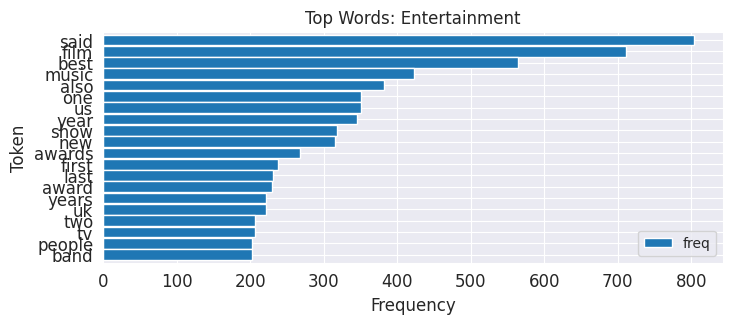

In [ ]:
freq_df_ent = count_words(df_ent)

ax = freq_df_ent.head(20).plot(kind='barh', width=0.95, figsize=(8,3))
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words: Entertainment')

  0%|          | 0/503 [00:00<?, ?it/s]

[Text(0.5, 0, 'Frequency'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'Top Words: Business')]

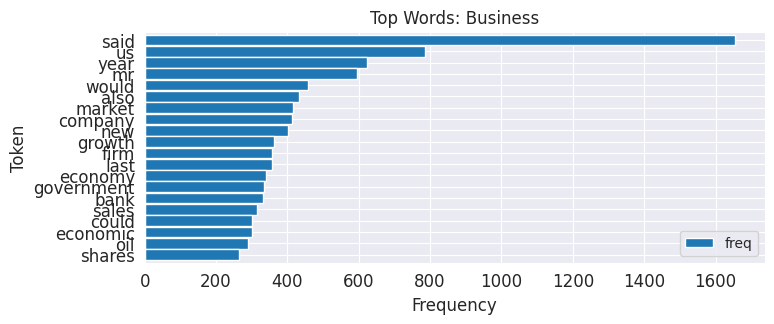

In [ ]:
freq_df_bus = count_words(df_bus)
ax = freq_df_bus.head(20).plot(kind='barh', width=0.95, figsize=(8,3))
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words: Business')

  0%|          | 0/403 [00:00<?, ?it/s]

[Text(0.5, 0, 'Frequency'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'Top Words: Politics')]

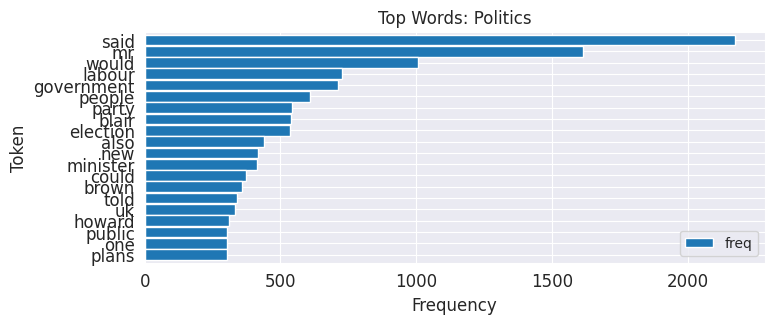

In [ ]:
freq_df_pol = count_words(df_pol)
ax = freq_df_pol.head(20).plot(kind='barh', width=0.95, figsize=(8,3))
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words: Politics')

  0%|          | 0/503 [00:00<?, ?it/s]

[Text(0.5, 0, 'Frequency'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'Top Words: Sports')]

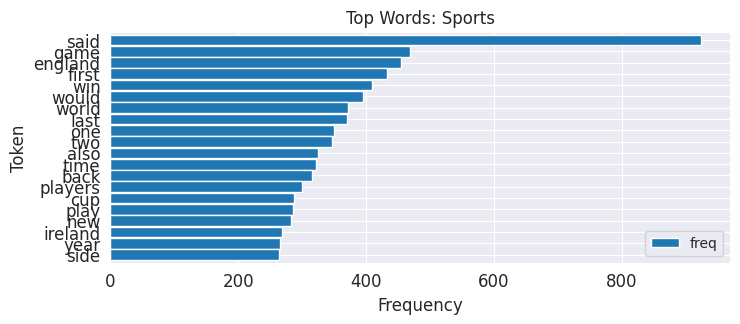

In [ ]:
freq_df_spo = count_words(df_spo)
ax = freq_df_spo.head(20).plot(kind='barh', width=0.95, figsize=(8,3))
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words: Sports')

  0%|          | 0/347 [00:00<?, ?it/s]

[Text(0.5, 0, 'Frequency'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'Top Words: Tech')]

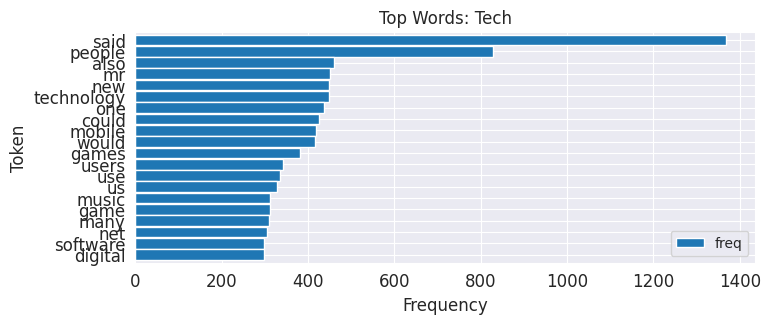

In [ ]:
freq_df_tec = count_words(df_tec)
ax = freq_df_tec.head(20).plot(kind='barh', width=0.95, figsize=(8,3))
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words: Tech')

## Word Cloud

In [ ]:
from wordcloud import WordCloud ###
from collections import Counter ###

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400,
                   background_color= "black", colormap="Paired",
                   max_font_size=150, max_words=max_words)

    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items()
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)

    plt.title(title)

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

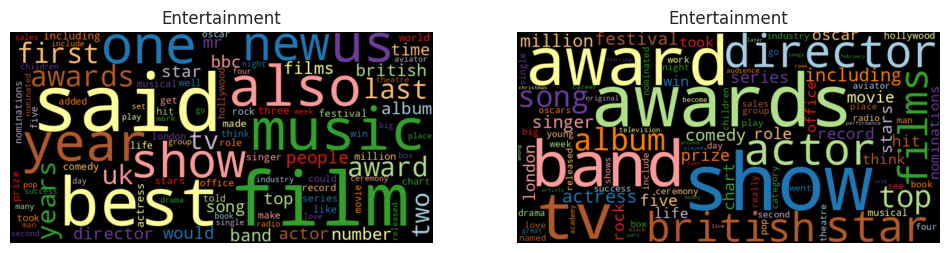

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)###
wordcloud(freq_df_ent['freq'], title= "Entertainment", max_words=100)
plt.subplot(1,2,2)###
wordcloud(freq_df_ent['freq'], title= "Entertainment", max_words=100, stopwords=freq_df.head(50).index)

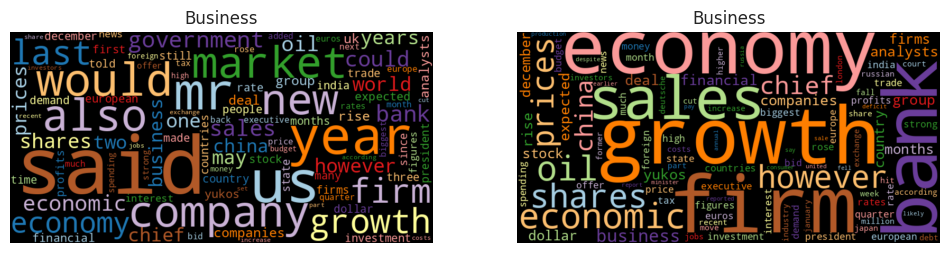

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)###
wordcloud(freq_df_bus['freq'], title= "Business", max_words=100)
plt.subplot(1,2,2)###
wordcloud(freq_df_bus['freq'], title= "Business", max_words=100, stopwords=freq_df.head(50).index)

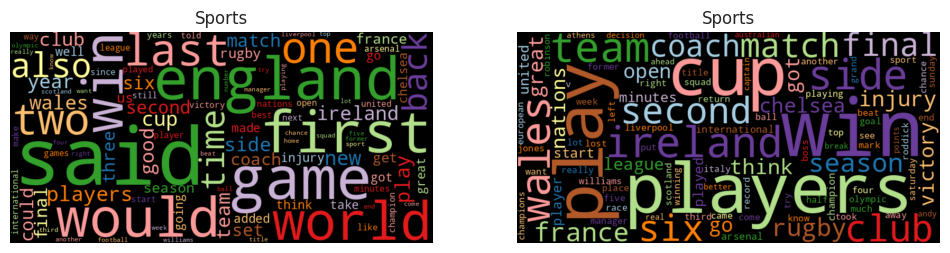

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)###
wordcloud(freq_df_spo['freq'], title= "Sports", max_words=100)
plt.subplot(1,2,2)###
wordcloud(freq_df_spo['freq'], title= "Sports", max_words=100, stopwords=freq_df.head(50).index)

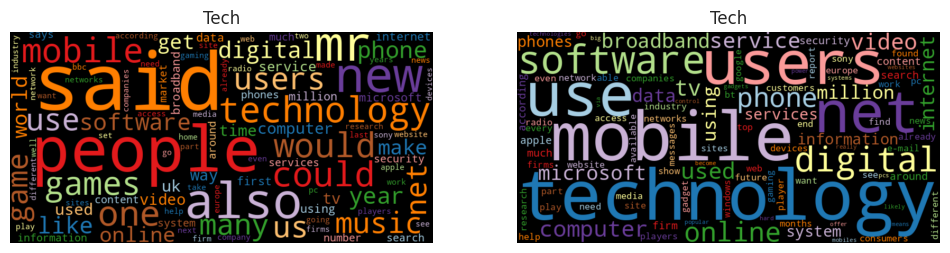

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)###
wordcloud(freq_df_tec['freq'], title="Tech", max_words=100)
plt.subplot(1,2,2)###
wordcloud(freq_df_tec['freq'], title="Tech", max_words=100, stopwords=freq_df.head(50).index)

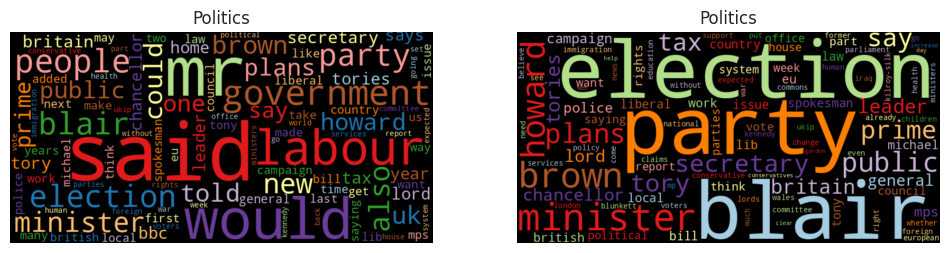

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)###
wordcloud(freq_df_pol['freq'], title="Politics", max_words=100)
plt.subplot(1,2,2)###
wordcloud(freq_df_pol['freq'], title="Politics", max_words=100, stopwords=freq_df.head(50).index)

---

## TF-IDF Word Frequency

In [ ]:
def compute_idf(df, column='tokens', preprocess=None, min_df=2):

    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(set(tokens))

    # count tokens
    counter = Counter()
    df[column].progress_map(update)

    # create data frame and compute idf
    idf_df = pd.DataFrame.from_dict(counter, orient='index', columns=['df'])
    idf_df = idf_df.query('df >= @min_df')
    idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1
    idf_df.index.name = 'token'
    return idf_df

In [ ]:
idf_df = compute_idf(df, column="lemmas")

  0%|          | 0/2125 [00:00<?, ?it/s]

In [ ]:
# not in book: for more data: joining is faster
freq_df = count_words(df)
freq_df = freq_df.join(idf_df)
freq_df['tfidf'] = (1 + np.log10(freq_df['freq'])) * freq_df['idf']

  0%|          | 0/2125 [00:00<?, ?it/s]

In [ ]:
freq_df.sort_values('tfidf', ascending=False).head(20)

freq   df  idf  tfidf
token                           
years       967 2.00 7.07  28.17
players     474 2.00 7.07  25.98
going       595 3.00 6.66  25.15
saying      312 2.00 7.07  24.70
less        275 2.00 7.07  24.31
went        262 2.00 7.07  24.16
companies   411 3.00 6.66  24.08
held        248 2.00 7.07  23.99
looking     247 2.00 7.07  23.98
users       351 3.00 6.66  23.62
came        349 3.00 6.66  23.61
consumers   159 2.00 7.07  22.63
fell        150 2.00 7.07  22.45
stars       142 2.00 7.07  22.28
known       140 2.00 7.07  22.24
hopes       136 2.00 7.07  22.15
devices     131 2.00 7.07  22.03
expected    475 6.00 5.97  21.95
numbers     126 2.00 7.07  21.91
laws        124 2.00 7.07  21.87

In [ ]:
# freq_df_bus['tfidf'] = (1 + np.log10(freq_df_bus['freq'])) * freq_df['idf']
# freq_df_ent['tfidf'] = (1 + np.log10(freq_df_ent['freq'])) * freq_df['idf']
# freq_df_pol['tfidf'] = (1 + np.log10(freq_df_pol['freq'])) * freq_df['idf']
# freq_df_spo['tfidf'] = (1 + np.log10(freq_df_spo['freq'])) * freq_df['idf']
# freq_df_tec['tfidf'] = (1 + np.log10(freq_df_tec['freq'])) * freq_df['idf']

freq_df_bus['tfidf'] = freq_df_bus['freq'] * freq_df['idf']
freq_df_ent['tfidf'] = freq_df_ent['freq'] * freq_df['idf']
freq_df_pol['tfidf'] = freq_df_pol['freq'] * freq_df['idf']
freq_df_spo['tfidf'] = freq_df_spo['freq'] * freq_df['idf']
freq_df_tec['tfidf'] = freq_df_tec['freq'] * freq_df['idf']

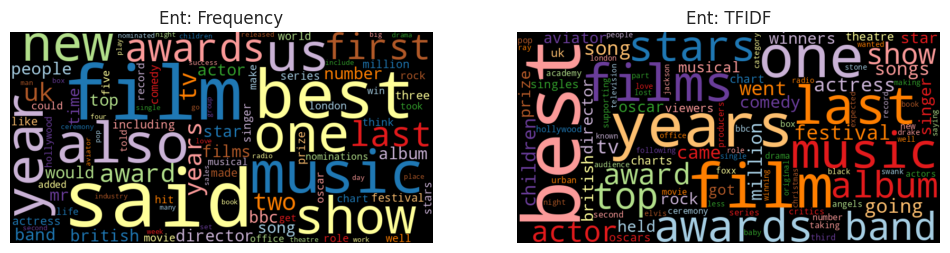

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)###
wordcloud(freq_df_ent['freq'], title="Ent: Frequency", max_words=100)
plt.subplot(1,2,2)###
wordcloud(freq_df_ent['tfidf'], title="Ent: TFIDF", max_words=100)

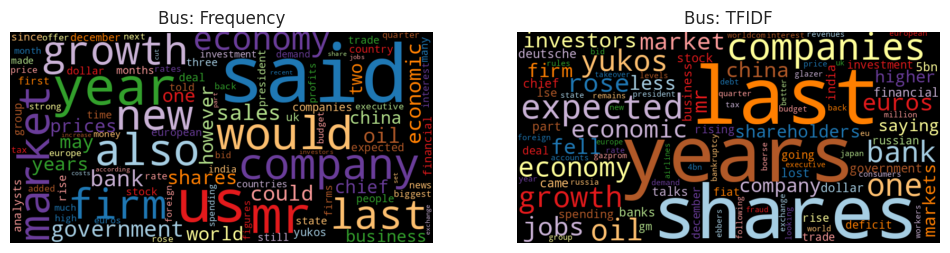

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)###
wordcloud(freq_df_bus['freq'], title="Bus: Frequency", max_words=100)
plt.subplot(1,2,2)###
wordcloud(freq_df_bus['tfidf'], title="Bus: TFIDF", max_words=100)

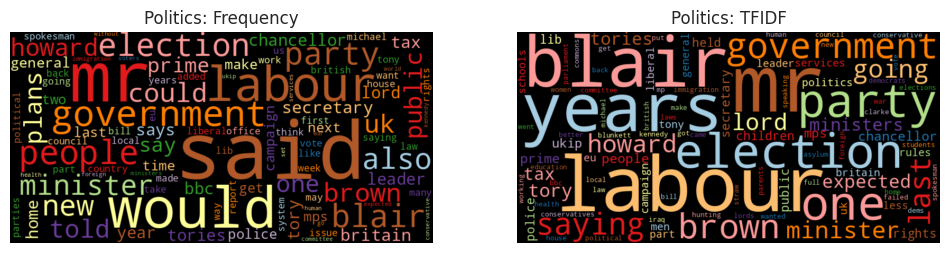

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)###
wordcloud(freq_df_pol['freq'], title="Politics: Frequency", max_words=100)
plt.subplot(1,2,2)###
wordcloud(freq_df_pol['tfidf'], title="Politics: TFIDF", max_words=100)

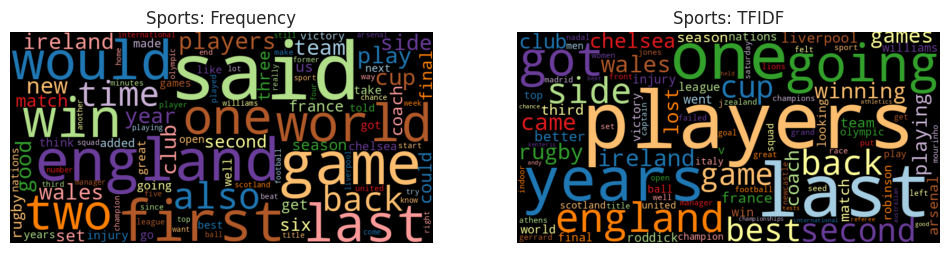

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)###
wordcloud(freq_df_spo['freq'], title="Sports: Frequency", max_words=100)
plt.subplot(1,2,2)###
wordcloud(freq_df_spo['tfidf'], title="Sports: TFIDF", max_words=100)

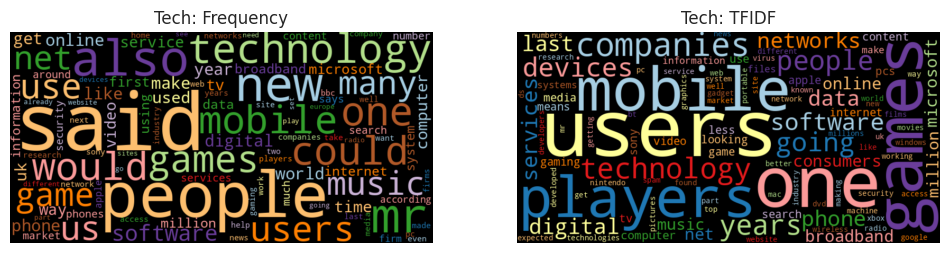

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)###
wordcloud(freq_df_tec['freq'], title="Tech: Frequency", max_words=100)
plt.subplot(1,2,2)###
wordcloud(freq_df_tec['tfidf'], title="Tech: TFIDF", max_words=100)

---

# Model Development & Evaluation

In [ ]:
import matplotlib.pyplot as plt
import html
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
## Depracated:
# from sklearn.metrics import plot_confusion_matrix
## New version:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier

In [ ]:
# Loading the balanced dataframe

df = df[['text', 'category']]
df = df.dropna()

# Step 2 - Train-Test Split
X_train, X_test, Y_train, Y_test = train_test_split(df['text'],
                                                    df['category'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df['category'])
print('Size of Training Data ', X_train.shape[0])
print('Size of Test Data ', X_test.shape[0])

# Step 3 - Training the Machine Learning model

tfidf = TfidfVectorizer(min_df=10, ngram_range=(1, 2), stop_words="english")
X_train_tf = tfidf.fit_transform(X_train)

model1 = SVC(kernel="linear", C=1, probability=True, random_state=42)
model1.fit(X_train_tf, Y_train)

# Step 4 - Model Evaluation

X_test_tf = tfidf.transform(X_test)
Y_pred = model1.predict(X_test_tf)
print('Accuracy Score - ', accuracy_score(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

Size of Training Data  1700
Size of Test Data  425
Accuracy Score -  0.9647058823529412
               precision    recall  f1-score   support

     business       0.95      0.93      0.94       100
entertainment       0.95      1.00      0.97        74
     politics       0.97      0.96      0.97        81
        sport       0.98      0.99      0.99       101
         tech       0.97      0.94      0.96        69

     accuracy                           0.96       425
    macro avg       0.96      0.97      0.96       425
 weighted avg       0.96      0.96      0.96       425



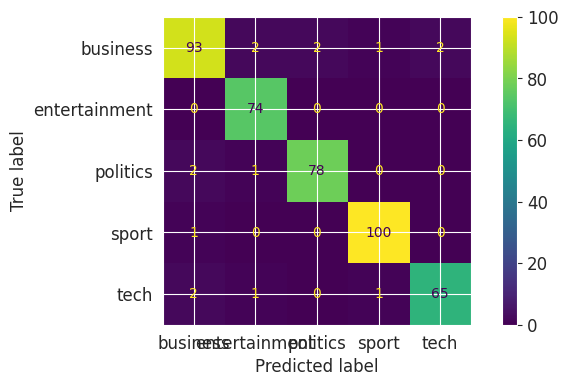

In [ ]:
cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = model1.classes_)
disp.plot()
plt.show()

# Cross Validation

In [ ]:
# # Vectorization

# tfidf_cv = TfidfVectorizer(min_df = 10, ngram_range=(1,2), stop_words="english")
# df_tf = tfidf_cv.fit_transform(df['text']).toarray()

# # Cross Validation with 5 folds

# scores = cross_val_score(estimator=model1,
#                          X=df_tf,
#                          y=df['category'],
#                          cv=5)

# print ("Validation scores from each iteration of the cross validation ", scores)
# print ("Mean value across of validation scores ", scores.mean())
# print ("Standard deviation of validation scores ", scores.std())

# Hyperparameter Tuning

In [ ]:
# training_pipeline = Pipeline(
#     steps=[('tfidf', TfidfVectorizer(
#         stop_words="english")), ('model',
#                                  SVC(kernel="linear", C=1, probability=True, random_state=42))])

# grid_param = [{
#     'tfidf__min_df': [5, 10],
#     'tfidf__ngram_range': [(1, 3), (1, 6)],
#     'model__penalty': ['l2'],
#     'model__loss': ['hinge'],
#     'model__max_iter': [10000]
# }, {
#     'tfidf__min_df': [5, 10],
#     'tfidf__ngram_range': [(1, 3), (1, 6)],
#     'model__C': [1, 10],
#     'model__tol': [1e-2, 1e-3]
# }]

# gridSearchProcessor = GridSearchCV(estimator=training_pipeline,
#                                    param_grid=grid_param,
#                                    cv=5)
# gridSearchProcessor.fit(df['text'], df['category'])

# best_params = gridSearchProcessor.best_params_
# print("Best alpha parameter identified by grid search ", best_params)

# best_result = gridSearchProcessor.best_score_
# print("Best result identified by grid search ", best_result)

In [ ]:
# gridsearch_results = pd.DataFrame(gridSearchProcessor.cv_results_)
# gridsearch_results[['rank_test_score', 'mean_test_score',
#                     'params']].sort_values(by=['rank_test_score'])[:5]

# CV, HPO, Evaluation

In [ ]:
# # Flag that determines the choice of SVC (True) and LinearSVC (False)
# runSVC = True

# # # Loading the dataframe

# # file = "eclipse_jdt.csv"
# # file = f"{BASE_DIR}/data/jdt-bugs-dataset/eclipse_jdt.csv.gz" ### real location
# # df = pd.read_csv(file)
# # df = df[['Title', 'Description', 'Component']]
# # df = df.dropna()
# # df['text'] = df['Title'] + df['Description']
# # df = df.drop(columns=['Title', 'Description'])

# # # Step 1 - Data Preparation
# # df['text'] = df['text'].apply(clean)
# # df = df[df['text'].str.len() > 50]

# # if (runSVC):
# #     # Sample the data when running SVC to ensure reasonable run-times
# #     df = df.groupby('Component', as_index=False).apply(pd.DataFrame.sample,
# #                                                        random_state=42,
# #                                                        frac=.2)

# # Step 2 - Train-Test Split
# X_train, X_test, Y_train, Y_test = train_test_split(df['text'],
#                                                     df['category'],
#                                                     test_size=0.2,
#                                                     random_state=42,
#                                                     stratify=df['category'])
# print('Size of Training Data ', X_train.shape[0])
# print('Size of Test Data ', X_test.shape[0])

# # Step 3 - Training the Machine Learning model
# tfidf = TfidfVectorizer(stop_words="english")

# if (runSVC):
#     model = SVC(random_state=42, probability=True)
#     grid_param = [{
#         'tfidf__min_df': [5, 10],
#         'tfidf__ngram_range': [(1, 3), (1, 6)],
#         'model__C': [1, 100],
#         'model__kernel': ['linear']
#     }]
# else:
#     model = LinearSVC(random_state=42, tol=1e-5)
#     grid_param = {
#         'tfidf__min_df': [5, 10],
#         'tfidf__ngram_range': [(1, 3), (1, 6)],
#         'model__C': [1, 100],
#         'model__loss': ['hinge']
#     }

# training_pipeline = Pipeline(
#     steps=[('tfidf', TfidfVectorizer(stop_words="english")), ('model', model)])

# gridSearchProcessor = GridSearchCV(estimator=training_pipeline,
#                                    param_grid=grid_param,
#                                    cv=5)

# gridSearchProcessor.fit(X_train, Y_train)

# best_params = gridSearchProcessor.best_params_
# print("Best alpha parameter identified by grid search ", best_params)

# best_result = gridSearchProcessor.best_score_
# print("Best result identified by grid search ", best_result)

# best_model = gridSearchProcessor.best_estimator_

# # Step 4 - Model Evaluation

# Y_pred = best_model.predict(X_test)
# print('Accuracy Score - ', accuracy_score(Y_test, Y_pred))
# print(classification_report(Y_test, Y_pred))

In [ ]:
clf = DummyClassifier(strategy='most_frequent', random_state=21)
clf.fit(X_train, Y_train)
Y_pred_baseline = clf.predict(X_test)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred_baseline))

Accuracy Score -  0.23529411764705882


In [ ]:
## Create a dataframe combining the Title and Description,
## Actual and Predicted values that we can explore
frame = { 'text': X_test, 'actual': Y_test, 'predicted': Y_pred }
result = pd.DataFrame(frame)

In [ ]:
result[result['actual'] != result['predicted']].sample(2, random_state=42)

text  \
1385  Football Manager scores big time For the past decade or so the virtual football fans among us will have become used to the annual helping of Championship Manager (CM). Indeed, it seems like there has been a CM game for as many years as there have been PCs. However, last year was the final time that developers Sports Interactive (SI) and publishers Eidos would work together. They decided to go their separate ways, and each kept a piece of the franchise. SI kept the game's code and database, and Eidos retained rights to the CM brand, and the look and feel of the game. So at the beginning of this year, fans faced a new situation. Eidos announced the next CM game, with a new team to develop it from scratch, whilst SI developed the existing code further to be released, with new publishers Sega, under the name Football Manager. So what does this mean? Well, Football Manager is the spiritual successor to the CM series, and it has been released earlier than expected. At this point CM5 looks like it will ship early next year. But given that Football Manager 2005 is by and large the game that everybody knows and loves, how does this new version shape up? A game like FM2005 could blind you with statistics. It has an obscene number of playable leagues, an obscene number of manageable teams and a really obscene number of players and staff from around the world in the database, with stats faithfully researched and compiled by a loyal army of fans. But that does not do justice to the game really. What we are talking about is the most realistic and satisfying football management game to ever grace the Earth. You begin by picking the nations and leagues you want to manage teams from, for instance England and Scotland. That will give you a choice not just of the four main Scottish leagues, but the English Premiership all the way down to the Conference North and South. Of course you might be looking for European glory, or to get hold of Abramovich's millions, in which case you can take control at Chelsea, or even Barcelona, Real Madrid, AC Milan ... the list goes on a very long way. Once in a team you will be told by the board what they expect of you. Sometimes it is promotion, or a place in Europe, sometimes it is consolidation or a brave relegation battle. It might even be a case of Champions or else. Obviously the expectations are linked to the team you choose, so choose wisely. Then it is time to look at your squad, work out your tactics, seeing how much cash, if any, you have got to splash, having a look at the transfer market, sorting out the training schedule and making sure your backroom staff are up to it. Then bring on the matches, which are once more available in the ever-improving top down 2D view. With the exception of the improved user interface on the surface, not much else seems to have changed. However, there have been a lot of changes under the bonnet as well things like the manager mind-games, which let you talk to the media about the opposition bosses. The match engine is also much improved, and it is more of a joy than ever to watch. In fact just about every area of the game has been tweaked, and it leads to an ever more immersive experience. With a game that is so complex and so open-ended, there are of course a few glitches, but nowhere near the sorts of problems that have blighted previous releases. With so many calculations to perform the game can take some time to process in between matches, though there have been improvements in this area. And a sport like football, which is so high profile and unpredictable itself, can never be modelled quite to everybody's satisfaction. But this time around a great deal of hard work has been put in to ensure that any oddities that do crop up are cosmetic only, and do not affect gameplay. And if there are problems further down the line, Sports Interactive have indicated their usual willingness to support and develop the game as far as possible. In all there are many more

---

# Document Similarity using TFIDF matrix

In [ ]:
df[df['text'].str.contains('box office')]['text'].head(2)

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   De Niro film leads US box office Film star Robert De Niro has returned to the top of the North American box office with his film Hide and Seek. The thriller shot straight to the number one spot after taking $22m (A£11.7m) at the box office. De Niro recently spent three weeks at the top with comedy Meet The Fockers, which was at number five this week. Oscar hopefuls The Aviator, Million Dollar Baby and Sideways all cashed in on their multiple nominations with stronger ticket sales. In Hide and Seek, De Niro plays a widower whose daughter has a creepy imaginary friend. Despite lukewarm reviews from critics, the film took more than the expected $18m (A£9.5m). "The element of a real actor in a psychological thriller certainly elevated it," said Bruce Snyder, president of domestic distribution at 20th Century Fox. Clint Eastwood's Million Dollar Baby led the Oscar hopefuls with $11.8m (A£6.3m), coming in at number three during its first weekend of wide release. The Aviator, a film biography of Howard Hughes that leads the Oscar field with 11 nominations, was at number six for the weekend with $7.5m (A£4m). Oscar best-picture nominee Sideways entered the top ten for the first time in its 15th week of release. It came in seventh $6.3 (A£3.35m). Last week's top film, Ice Cube's road-trip comedy Are We There Yet?, slipped to second place with $17m (A£9m), while Coach Carter fell two places to number four, taking $8m (A£4.25m) in its third week. Rounding out the top ten

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# -----------------------------
# 2. Build TF-IDF matrix
# -----------------------------
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df['text'])

# -----------------------------
# 3. Compute cosine similarity
# -----------------------------
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# -----------------------------
# 4. Get top-n most similar documents
# -----------------------------
def get_top_n_similar(doc_index, n=3):
    """
    Returns top-n most similar documents for a given document index.

    Args:
        doc_index (int): Index of the target document in df.
        n (int): Number of similar documents to return.

    Returns:
        DataFrame: Top-n similar documents with similarity scores.
    """
    # Get similarity scores for target document
    sim_scores = list(enumerate(cosine_sim[doc_index]))
    # Sort by similarity score (highest first) but exclude the document itself
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n+1]  # skip itself

    # Build results dataframe
    similar_docs = pd.DataFrame({
        'doc_index': [i for i, _ in sim_scores],
        'similarity': [score for _, score in sim_scores],
        'category': [df.iloc[i]['category'] for i, _ in sim_scores],
        'text': [df.iloc[i]['text'] for i, _ in sim_scores]
    })

    return similar_docs

In [ ]:
# -----------------------------
# 5. Example usage
# -----------------------------
target_doc_index = 0  # First document
n = 5

print(f"Target Document:\n{df.iloc[target_doc_index]['text']}\n")
print("Top Similar Documents:\n")
print(get_top_n_similar(target_doc_index, n))

Target Document:
De Niro film leads US box office Film star Robert De Niro has returned to the top of the North American box office with his film Hide and Seek. The thriller shot straight to the number one spot after taking $22m (A£11.7m) at the box office. De Niro recently spent three weeks at the top with comedy Meet The Fockers, which was at number five this week. Oscar hopefuls The Aviator, Million Dollar Baby and Sideways all cashed in on their multiple nominations with stronger ticket sales. In Hide and Seek, De Niro plays a widower whose daughter has a creepy imaginary friend. Despite lukewarm reviews from critics, the film took more than the expected $18m (A£9.5m). "The element of a real actor in a psychological thriller certainly elevated it," said Bruce Snyder, president of domestic distribution at 20th Century Fox. Clint Eastwood's Million Dollar Baby led the Oscar hopefuls with $11.8m (A£6.3m), coming in at number three during its first weekend of wide release. The Aviator,

In [ ]:
df.loc[0, 'text']

'De Niro film leads US box office Film star Robert De Niro has returned to the top of the North American box office with his film Hide and Seek. The thriller shot straight to the number one spot after taking $22m (A£11.7m) at the box office. De Niro recently spent three weeks at the top with comedy Meet The Fockers, which was at number five this week. Oscar hopefuls The Aviator, Million Dollar Baby and Sideways all cashed in on their multiple nominations with stronger ticket sales. In Hide and Seek, De Niro plays a widower whose daughter has a creepy imaginary friend. Despite lukewarm reviews from critics, the film took more than the expected $18m (A£9.5m). "The element of a real actor in a psychological thriller certainly elevated it," said Bruce Snyder, president of domestic distribution at 20th Century Fox. Clint Eastwood\'s Million Dollar Baby led the Oscar hopefuls with $11.8m (A£6.3m), coming in at number three during its first weekend of wide release. The Aviator, a film biograp

In [ ]:
similar_docs = get_top_n_similar(doc_index=0, n=5)

In [ ]:
similar_docs

doc_index  similarity       category  \
0        161        0.44  entertainment   
1        118        0.44  entertainment   
2        361        0.38  entertainment   
3         91        0.30  entertainment   
4        317        0.29  entertainment   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  text  
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                       De Niro completes box office coup Robert De Niro has completed a transatlantic box office double by topping the UK and US film charts with two different films at the same time. Comedy sequel Meet the Fockers, in which he stars with Ben Stiller, Dustin Hoffman and Barbra Streisand, shot to the top of the UK chart at the weekend. It took A£7.2m in three days eight times more than the number two, Closer. Assault on Precinct 13 was in third. At the same time, US audiences were won over by his new thriller Hide and Seek. In Meet the Fockers, he picks up the role of an uptight father and ex-CIA agent from 2000 hit comedy, Meet the Parents. It is a big leap to his role in Hide and Seek, a supernatural horror in which he plays a widower whose daughter's imaginary friend turns nasty. In the UK box office chart, Meet the Fockers pushed Closer off the top spot while police action movie Assault On Precinct 13, starring rapper Ja Rule, made A£750,000 in its first weekend. London Underground thriller Creep was another new entry at six while quirky comedy Sideways, which got five Oscar nominations last week, entered in eighth place. The Oscar nominations do not seem to have had an impact on fans' choices at cinemas. Leading contenders The Aviator, Million Dollar Baby and Ray all suffered substantial drops in takings compared with the previous weekend.  
1                                                                                                             

---

## Prediction Diagnostics

In [ ]:
df['category'].value_counts()

category
sport            503
business         503
politics         403
entertainment    369
tech             347
Name: count, dtype: int64

In [ ]:
class_names = ["business", "entertainment", "politics", "sport", "tech"]
prob = model1.predict_proba(X_test_tf)
# new dataframe for explainable results
er = result.copy().reset_index()
for i, c in enumerate(class_names):
    er[c] = prob[:, i]

In [ ]:
er[["index", "actual", "predicted"] + class_names].sample(20, random_state=99)

index         actual      predicted  business  entertainment  politics  \
86     655          sport          sport      0.24           0.01      0.02   
147     35  entertainment  entertainment      0.00           1.00      0.00   
307    738          sport          sport      0.00           0.00      0.00   
243    526          sport          sport      0.00           0.00      0.00   
394    727          sport          sport      0.00           0.00      0.00   
406    694          sport          sport      0.00           0.00      0.00   
265    151  entertainment  entertainment      0.00           1.00      0.00   
32     558          sport          sport      0.00           0.00      0.00   
247     94  entertainment  entertainment      0.04           0.90      0.01   
388    749          sport          sport      0.00           0.00      0.00   
171   1496           tech           tech      0.00           0.00      0.00   
113    829          sport          sport      0.00           0.00      0.00   
155   2024       politics       politics      0.00           0.00      1.00   
126    920       business       business      0.99           0.00      0.00   
389   1124       business          sport      0.23           0.02      0.01   
338   1357       business       business      1.00           0.00      0.00   
200   1721           tech           tech      0.00           0.00      0.00   
7     1338       business       business      0.97           0.01      0.02   
383    232  entertainment  entertainment      0.02           0.82      0.13   
306    974       business       business      0.96           0.01      0.02   

     sport  tech  
86    0.73  0.01  
147   0.00  0.00  
307   1.00  0.00  
243   1.00  0.00  
394   1.00  0.00  
406   1.00  0.00  
265   0.00  0.00  
32    1.00  0.00  
247   0.05  0.01  
388   0.99  0.00  
171   0.00  1.00  
113   0.99  0.00  
155   0.00  0.00  
126   0.00  0.00  
389   0.73  0.01  
338   0.00  0.00  
200   0.00  1.00  
7     0.00  0.00  
383   0.01  0.03  
306   0.01  0.00

In [ ]:
er['max_probability'] = er[class_names].max(axis=1)
correct = (er[er['actual'] == er['predicted']])
wrong   = (er[er['actual'] != er['predicted']])

In [ ]:
len(wrong)

15

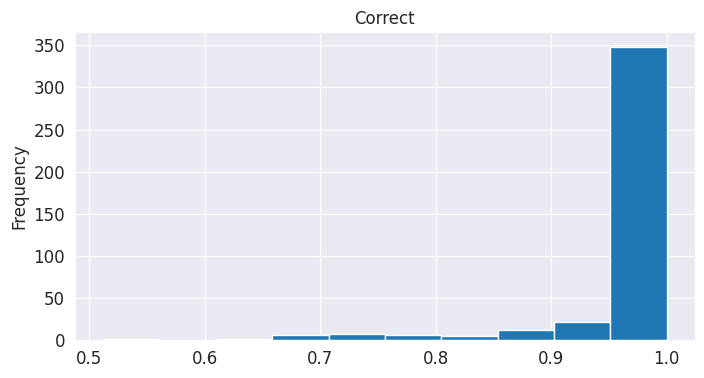

In [ ]:
import matplotlib.pyplot as plt
correct["max_probability"].plot.hist(title="Correct")
plt.savefig("correct.svg")

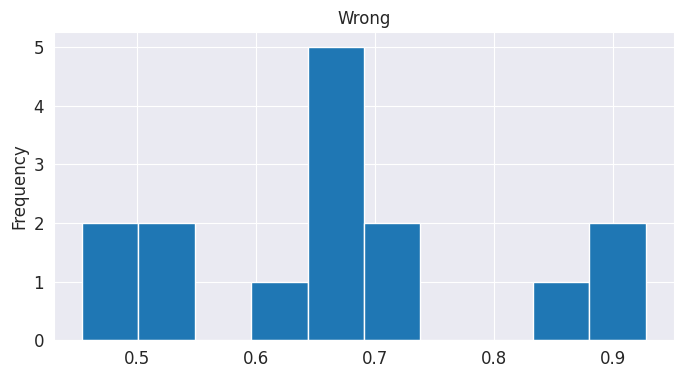

In [ ]:
wrong["max_probability"].plot.hist(title="Wrong")
plt.savefig("wrong.svg")

In [ ]:
print(classification_report(er["actual"], er["predicted"]))

               precision    recall  f1-score   support

     business       0.95      0.93      0.94       100
entertainment       0.95      1.00      0.97        74
     politics       0.97      0.96      0.97        81
        sport       0.98      0.99      0.99       101
         tech       0.97      0.94      0.96        69

     accuracy                           0.96       425
    macro avg       0.96      0.97      0.96       425
 weighted avg       0.96      0.96      0.96       425



---

# Coefficient Analysis

## Multi-class Classification with SVC()

* SVC and NuSVC implement the “one-versus-one” approach for multi-class classification. In total, n_classes * (n_classes - 1) / 2 classifiers are constructed and each one trains data from two classes. To provide a consistent interface with other classifiers, the decision_function_shape option allows to monotonically transform the results of the “one-versus-one” classifiers to a “one-vs-rest” decision function of shape (n_samples, n_classes), which is the default setting of the parameter (default=’ovr’).

* Reference: https://scikit-learn.org/stable/modules/svm.html#multi-class-classification

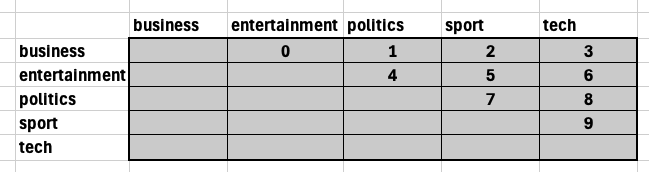

In [ ]:
from IPython.display import Image, display

image_path = '/content/drive/MyDrive/Colab/NLP/images/svc_coefficient_comparison_matrix.png'
# Display a local image (after uploading to Colab's file system)
display(Image(filename=image_path))

* SVC() `model1.coef_` provides coefficient values for each feature, though can only be analyzed by comparing 1 label vs another
* The label indices in the matrix correspond to which models are compared
  * Ex: Coefficients at index 0 show coefficient values when comparing `business` and `entertainment` labels
* Size of the coefficient matrix  = `(n_classes * (n_classes - 1) / 2 , num_features`
  * num_comparisons = `5 * (5-1) / 2 = 10`
  * `num_features = 5424` -> This is the size of the vocabulary

In [ ]:
print(X_test_tf.shape)
print(model1.coef_.shape)

(425, 5424)
(10, 5424)


## Business vs Entertainment: Coefficient Analysis

In [ ]:
# Business vs Entertainment
# coef_[0] yields a matrix for the Business vs Entertainment model coefficients
  # coef_[1] corresponds to Business vs Politics
  # coef_[2] corresponds to Business vs Sport
  # coef_[3] corresponds to Business vs Tech
  # coef_[4] corresponds to Entertainment vs Politics
coef = model1.coef_[0].toarray()[0]
vocabulary_positions = coef.argsort()
vocabulary = tfidf.get_feature_names_out()

In [ ]:
print(vocabulary)
print(vocabulary_positions)
print(len(vocabulary))
print(len(vocabulary_positions))
print(len(coef))

['000' '000 copies' '000 jobs' ... 'zero' 'zone' 'zurich']
[3222 1962 5067 ... 4421 1992  592]
5424
5424
5424


In [ ]:
top_words = 10
top_positive_coef = vocabulary_positions[-top_words:].tolist()
top_negative_coef = vocabulary_positions[:top_words].tolist()

In [ ]:
core_ui = pd.DataFrame([[vocabulary[c], coef[c]] for c in top_positive_coef + top_negative_coef],
                          columns=["feature", "coefficient"]).sort_values("coefficient")

In [ ]:
core_ui.set_index("feature")

coefficient
feature                
music             -1.49
film              -1.34
tv                -1.29
singer            -0.96
jackson           -0.81
star              -0.79
album             -0.78
films             -0.76
television        -0.74
book              -0.73
oil                0.65
business           0.68
food               0.68
firms              0.76
market             0.86
government         0.90
company            0.94
shares             1.05
firm               1.06
bank               1.13

Text(0.5, 1.0, 'Business (+) vs. Entertainment (-)')

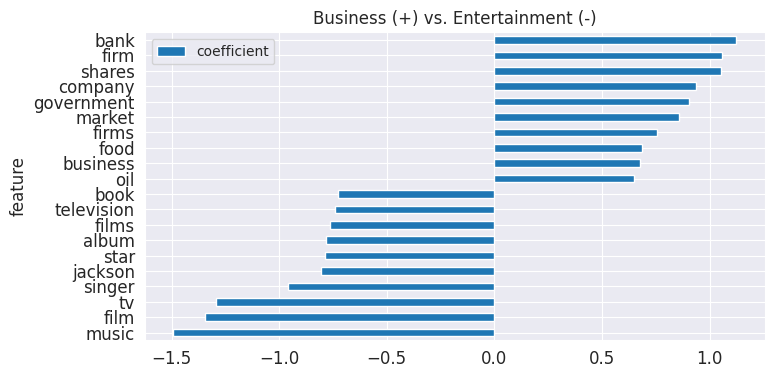

In [ ]:
# core_ui.set_index("feature").plot.barh(color=[['red']*10 + ['green']*10])
core_ui.set_index("feature").plot.barh()
plt.savefig("coefficients-core-ui.svg")
plt.title("Business (+) vs. Entertainment (-)")

---

# Explainability with LIME: Explaining Individual Predictions

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=10accbf1e3fc96b3307a29839a2f7359d79b7685e8aeccdbc26756ba457a8ef5
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
from sklearn.pipeline import make_pipeline
pipeline = make_pipeline(tfidf, model1)

In [ ]:
print(class_names)
print(pipeline.predict_proba(["The team captain retired after the championship game"]))

['business', 'entertainment', 'politics', 'sport', 'tech']
[[0.01243865 0.01091885 0.0087937  0.93040016 0.03744863]]


In [ ]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names)

In [ ]:
er[er["predicted"] != er["actual"]][["index", "actual", "predicted"] + class_names].head(5)

index    actual      predicted  business  entertainment  politics  sport  \
25    1032  business           tech      0.49           0.03      0.02   0.00   
27    1832  politics       business      0.93           0.00      0.07   0.00   
49    1167  business  entertainment      0.15           0.53      0.14   0.02   
88     943  business       politics      0.04           0.03      0.92   0.01   
101   1978  politics       business      0.66           0.06      0.23   0.03   

     tech  
25   0.46  
27   0.00  
49   0.17  
88   0.00  
101  0.02

In [ ]:
id = 25
print('Document id: %d' % id)
print('Predicted class =', er.iloc[id]["predicted"])
print('True class: %s' % er.iloc[id]["actual"])

Document id: 25
Predicted class = tech
True class: business


In [ ]:
print(f'Class Labels: {class_names}\nClass Label Indices: {[0, 1, 2, 3, 4]}')

Class Labels: ['business', 'entertainment', 'politics', 'sport', 'tech']
Class Label Indices: [0, 1, 2, 3, 4]


In [ ]:
# compare relevant features for labels 0: business and 4: tech
exp = explainer.explain_instance(result.iloc[id]["text"], pipeline.predict_proba, num_features=10, labels=[0, 4])
print('Explanation for class %s' % class_names[0])
print('\n'.join(map(str, exp.as_list(label=0))))
print()
print('Explanation for class %s' % class_names[4])
print('\n'.join(map(str, exp.as_list(label=4))))

Explanation for class business
(np.str_('consumers'), -0.13081017639512768)
(np.str_('internet'), -0.11273669936422084)
(np.str_('people'), -0.11177772002023527)
(np.str_('bank'), 0.0873528481678562)
(np.str_('fraud'), 0.08395601046780561)
(np.str_('Commission'), 0.07568746656277246)
(np.str_('complaints'), 0.07046039188687309)
(np.str_('concerned'), -0.046327710253620674)
(np.str_('information'), -0.04404223175086582)
(np.str_('use'), -0.0364973306093357)

Explanation for class tech
(np.str_('consumers'), 0.15062199589609757)
(np.str_('internet'), 0.14849759992627104)
(np.str_('people'), 0.11738800867273384)
(np.str_('complaints'), -0.10953234072375802)
(np.str_('fraud'), -0.06364107478133595)
(np.str_('bank'), -0.061208501926817996)
(np.str_('information'), 0.049735252928426434)
(np.str_('use'), 0.045705644523750824)
(np.str_('Internet'), 0.03718643284728369)
(np.str_('concerned'), 0.034889094869275404)


In [ ]:
exp = explainer.explain_instance(result.iloc[id]["text"], pipeline.predict_proba, num_features=6, top_labels=3)
print(exp.available_labels()) # returns numpy array

# top potential labels for the text
# aligns with predicted probabilities
  # business: 0.49, tech: 0.46, entertainment: 0.03
print(f'Top Labels: {np.array(class_names)[exp.available_labels()]}') # converting class_names to np.array to index based on indicies

[np.int64(0), np.int64(4), np.int64(1)]
Top Labels: ['business' 'tech' 'entertainment']


In [ ]:
# visual representation of relevant features for each label
exp.show_in_notebook(text=False)

---

# ELI5: Explaining Individual Predictions

In [ ]:
!pip install eli5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.4/108.4 kB 3.0 MB/s eta 0:00:00


In [ ]:
from sklearn.linear_model import SGDClassifier
svm = SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3, random_state=42)
svm.fit(X_train_tf, Y_train)
Y_pred_svm = svm.predict(X_test_tf)
print(classification_report(Y_test, Y_pred_svm))

               precision    recall  f1-score   support

     business       0.96      0.93      0.94       100
entertainment       0.95      1.00      0.97        74
     politics       0.97      0.96      0.97        81
        sport       0.98      0.99      0.99       101
         tech       0.97      0.96      0.96        69

     accuracy                           0.97       425
    macro avg       0.97      0.97      0.97       425
 weighted avg       0.97      0.97      0.97       425



In [ ]:
import eli5
eli5.show_weights(svm, top=20, vec=tfidf, target_names=class_names)

In [ ]:
eli5.show_prediction(svm, X_test.iloc[id],  vec=tfidf, target_names=class_names)

---